In [8]:
import numpy as np
import pandas as pd
import shap
import torch
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [7]:

model = torch.load(r"C:\Users\parde\PycharmProjects\The-model\DeepFakeModel_lr=0.0018225174677877769_bs=16_drop=0.62_layers=4_valloss=0.0768.pth",  map_location=torch.device('cuda'))
model.eval()

# Load the CSV file (Upload your file)
train_csv = "train_30h.csv" 
df = pd.read_csv(train_csv)

# Extract features (from the third column to the second last column)
X_train = df.iloc[:, 2:-1]  # Adjust indexing based on your file structure
y_train = df.iloc[:, -1]  # Last column as labels

# Store feature names BEFORE converting X_train to a tensor
feature_names = X_train.columns.tolist()  # Ensure this is a DataFrame before tensor conversion

test_csv = "test_30h.csv" 
test_df = pd.read_csv(test_csv)

X_test = test_df.iloc[:, 2:-1]
y_test = test_df.iloc[:, -1]

# Convert to Torch Tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to("cuda")
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to("cuda") 

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to("cuda")
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to("cuda")  # Change dtype if using regression

# 🟢 Step 1: Compute Random Forest MDI (Mean Decrease in Impurity)
rf = RandomForestClassifier(n_estimators=2000, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
mdi_importance = rf.feature_importances_

# 🟢 Step 2: Compute MDA (Mean Decrease in Accuracy)
mda_results = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
mda_importance = mda_results.importances_mean  # Take the mean across permutations

# 🟢 Step 3: Compute Shuffling MDA (Alternative Permutation Method)
def compute_shuffled_mda():
    
    def evaluate_model(model, X, y):
        model.eval()
        with torch.no_grad():
            y_pred = model(X)
    
            if y_pred.shape[1] == 1:  # Binary Classification (Single output neuron)
                y_pred = (y_pred > 0.5).int()
                y_pred = y_pred.squeeze(dim=1)  # Remove extra dimension
            else:  # Multi-Class Classification
                y_pred = y_pred.argmax(dim=1)  # Get class index
    
            accuracy = (y_pred == y).float().mean().item()
        return accuracy
    
    # Compute Baseline Accuracy
    baseline_acc = evaluate_model(model, X_test_tensor, y_test_tensor)

    # Compute Permutation Importance
    feature_importance = []
    num_repeats = 500  # How many times to shuffle each feature
    
    for col in range(X_test.shape[1]):  # Iterate over each feature
        acc_drops = []
        
        for _ in range(num_repeats):
            X_test_permuted = X_test_tensor.clone()  # Clone to avoid modifying original test set
            X_test_permuted[:, col] = X_test_permuted[:, col][torch.randperm(X_test_permuted.shape[0])]  # Shuffle feature
            
            permuted_acc = evaluate_model(model, X_test_permuted, y_test_tensor)
            acc_drops.append(baseline_acc - permuted_acc)  # Difference from baseline accuracy
        
        feature_importance.append(np.mean(acc_drops))  # Average over repeats
    return feature_importance
shuffling_mda_importance = compute_shuffled_mda()

# 🟢 Step 4: Compute SHAP Importance
# Store feature names BEFORE converting X_train to tensor
feature_names = X_train.columns.tolist()

# Define a wrapper function for SHAP
def model_wrapper(X):
    X_tensor = torch.tensor(X, dtype=torch.float32).to("cuda")  # Ensure tensor format
    with torch.no_grad():
        return model(X_tensor).cpu().numpy()  # Get predictions and return as NumPy

# Use SHAP's KernelExplainer
explainer = shap.Explainer(model_wrapper, X_train_tensor.cpu().numpy())

# Compute SHAP values
shap_values = explainer(X_test_tensor.cpu().numpy())

# Convert SHAP values to NumPy
shap_values_array = shap_values.values  # (samples, features)

# Compute mean absolute SHAP value per feature
shap_importance = np.mean(np.abs(shap_values_array), axis=0)

# 🟢 Step 5: Normalize All Importances (Min-Max Scaling)
def normalize(values):
    return (values - np.min(values)) / (np.max(values) - np.min(values) + 1e-8)  # Prevent division by zero

mdi_importance_norm = normalize(mdi_importance)
mda_importance_norm = normalize(mda_importance)
shuffling_mda_importance_norm = normalize(shuffling_mda_importance)
shap_importance_norm = normalize(shap_importance)

# 🟢 Step 6: Combine Importances into a Final Score
final_importance = (mdi_importance_norm + mda_importance_norm + shuffling_mda_importance_norm + shap_importance_norm) / 4  # Equal weight to all

# 🟢 Step 7: Create a Final Ranking DataFrame
feature_ranking_df = pd.DataFrame({
    "Feature": feature_names,
    "MDI Importance": mdi_importance,
    "MDA Importance": mda_importance,
    "Shuffling MDA Importance": shuffling_mda_importance,
    "SHAP Importance": shap_importance,
    "Final Score": final_importance
}).sort_values(by="Final Score", ascending=False)

feature_ranking_df

C:\Users\parde\AppData\Local\Temp\ipykernel_31300\3137517079.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(r"C:\Users\parde\PycharmProjects\The-mode

,Feature,MDI Importance,MDA Importance,Shuffling MDA Importance,SHAP Importance,Final Score
23,median_16000,0.092297,1.397690e-01,0.046936,0.077974,1.000000
51,std_16000,0.038913,4.909241e-03,0.017640,0.043690,0.354020
26,variance_255,0.007410,5.363036e-04,0.028253,0.030040,0.269702
39,std_150,0.011367,2.681518e-03,0.010864,0.032645,0.204237
112,mfcc16_mean,0.018017,1.567657e-03,0.005088,0.033098,0.192555
...,...,...,...,...,...,...
144,mfcc18_var,0.002093,-8.250825e-04,-0.000564,0.001671,0.014148
141,mfcc15_var,0.002788,-8.663366e-04,-0.001592,0.002637,0.013874
82,mfcc16_std,0.001688,-2.220446e-17,-0.000515,0.001360,0.013744
6,avg_letter_per_second,0.001405,9.488449e-04,-0.000377,0.000704,0.013235


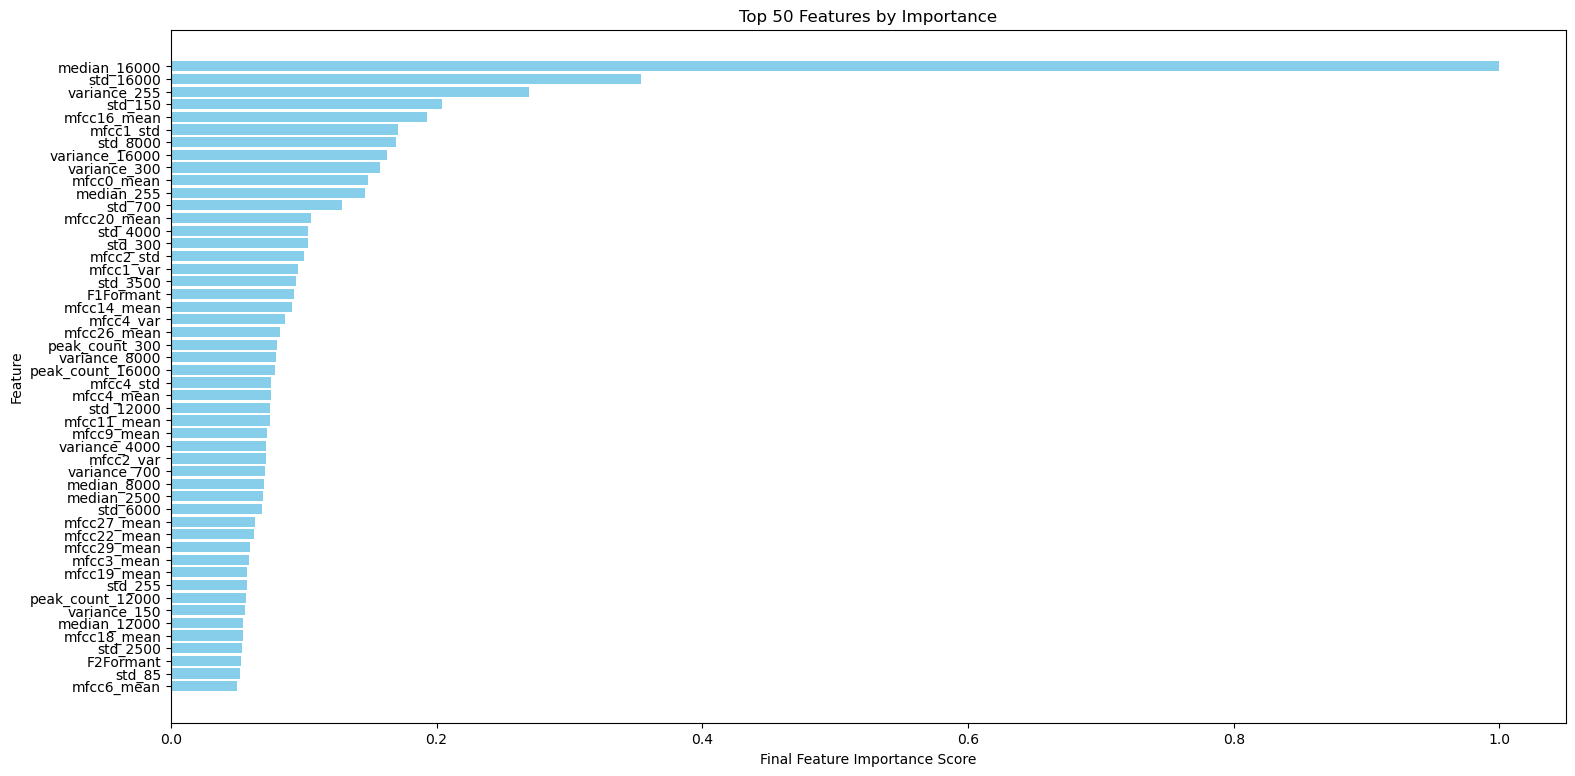

In [10]:
# 🟢 Step 8: Visualization - Top 20 Features
plt.figure(figsize=(18, 9))
top_50_features = feature_ranking_df.head(50)
plt.barh(top_50_features["Feature"], top_50_features["Final Score"], color='skyblue')
plt.xlabel("Final Feature Importance Score")
plt.ylabel("Feature")
plt.title("Top 50 Features by Importance")
plt.gca().invert_yaxis()  # Highest scores at the top
plt.show()